# (Non-)Interruptibility of Sarsa($\lambda$) and Q-Learning

%load_md intro.md

%load_md method.md

### Setup

In [60]:
import functools
import itertools
import math

import matplotlib
from matplotlib import pyplot
import numpy as np

import sys
sys.path.append("..")
from hiora_cartpole import features
from hiora_cartpole import fourier_fa
from hiora_cartpole import easytile_fa
from hiora_cartpole import offswitch_hfa
from hiora_cartpole import linfa
from hiora_cartpole import driver
from hiora_cartpole import interruptibility

import gym_ext.tools as gym_tools

import gym
import gym.wrappers

A bit of extra work is required, because I run several training rounds in parallel. First, define functions that return environments. OffSwitchCartpole has the same physics as CartPole. The only difference is that it interrupts the agent when its $x$-coordinate becomes greater than $1.0$. It signals the interruption to the agent as part of the observation it returns.

In [17]:
def make_CartPole():
    return gym.make("CartPole-v0")

def make_OffSwitchCartpole():
    return gym.make("OffSwitchCartpole-v0")

Functions mapping observations to features. The observations are not really clipped. I just make sure that the program tells me when the observations fall outside the expected range. (See [here](https://gitter.im/openai/gym?at=57e23d12aabc89857fbd7c9c) for why this is necessary.)

In [22]:
clipped_high = np.array([2.5, 3.6, 0.27, 3.7])
clipped_low  = -clipped_high
state_ranges = np.array([clipped_low, clipped_high])

four_n_weights, four_feature_vec \
    = fourier_fa.make_feature_vec(state_ranges,
                                  n_acts=2,
                                  order=3)

ofour_n_weights, ofour_feature_vec \
    = offswitch_hfa.make_feature_vec(four_feature_vec, four_n_weights)
    
skip_offswitch_clip = functools.partial(
                          gym_tools.apply_to_snd, 
                          functools.partial(gym_tools.warning_clip_obs, ranges=state_ranges))

  
def ordinary_xpos(o):
    return o[0] # Don't remember why I didn't use operator.itemgetter.

Functions returning learners. The resulting learners are essentially the same. Only the stuff that has to do with mapping observations to features is slightly different, because the OffSwitchCartpole returns extra information, as I said above.

In [19]:
def make_uninterruptable_experience(choose_action=linfa.choose_action_Sarsa):
    return linfa.init(lmbda=0.9,
                        init_alpha=0.001,
                        epsi=0.1,
                        feature_vec=four_feature_vec,
                        n_weights=four_n_weights,
                        act_space=env.action_space,
                        theta=None,
                        is_use_alpha_bounds=True,
                        map_obs=functools.partial(gym_tools.warning_clip_obs, ranges=state_ranges),
                        choose_action=choose_action)

def make_interruptable_experience(choose_action=linfa.choose_action_Sarsa):
    return linfa.init(lmbda=0.9,
                        init_alpha=0.001,
                        epsi=0.1,
                        feature_vec=ofour_feature_vec,
                        n_weights=ofour_n_weights,
                        act_space=env.action_space,
                        theta=None,
                        is_use_alpha_bounds=True,
                        map_obs=skip_offswitch_clip,
                        choose_action=choose_action)

In [2]:
cartpole = gym.make('OffSwitchCartpole-v0')
clipped_high = np.array([2.5, 3.6, 0.27, 3.7])
clipped_low  = -clipped_high
state_ranges = np.array([clipped_low, clipped_high])

[2016-09-26 15:25:34,812] Making new env: OffSwitchCartpole-v0


In [3]:
env = gym.wrappers.TraceRecordingWrapper(cartpole, "/tmp/cartpole-recordings")

In [20]:
four_n_weights, four_feature_vec \
    = fourier_fa.make_feature_vec(state_ranges,
                                  n_acts=2,
                                  order=3)

ofour_n_weights, ofour_feature_vec \
    = offswitch_hfa.make_feature_vec(four_feature_vec, four_n_weights)

    
skip_offswitch_clip = functools.partial(
                          gym_tools.apply_to_snd, 
                          functools.partial(gym_tools.warning_clip_obs, ranges=state_ranges))    

def make_interruptable_experience(choose_action=linfa.choose_action_Sarsa):
    return linfa.init(lmbda=0.9,
                        init_alpha=0.001,
                        epsi=0.1,
                        feature_vec=ofour_feature_vec,
                        n_weights=ofour_n_weights,
                        act_space=env.action_space,
                        theta=None,
                        is_use_alpha_bounds=True,
                        map_obs=skip_offswitch_clip,
                        choose_action=choose_action)

## Results

This is how one round of training might look if you let it run for a little longer than the 200 episodes used for the evaluation. The red line shows how the learning rate develops (or rather stays the same in this case).

INFO:gym.envs.registration:Making new env: OffSwitchCartpole-v0
[2016-10-24 14:57:07,066] Making new env: OffSwitchCartpole-v0


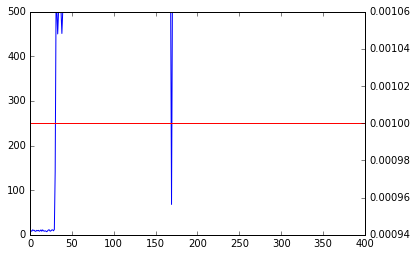

In [21]:
env         = make_OffSwitchCartpole()
fexperience = make_interruptable_experience()
fexperience, steps_per_episode, alpha_per_episode \
    = driver.train(env, linfa, fexperience, n_episodes=400, max_steps=500, is_render=False)
# Credits: http://matplotlib.org/examples/api/two_scales.html
fig, ax1 = pyplot.subplots()
ax1.plot(steps_per_episode, color='b')
ax2 = ax1.twinx()
ax2.plot(alpha_per_episode, color='r')
pyplot.show()

In [39]:
steps_per_episode = driver.exec_greedy(env, fexperience, n_episodes=7, max_steps=600, is_render=True)

In [22]:
env.num_crosses

[0.0, 4.0]

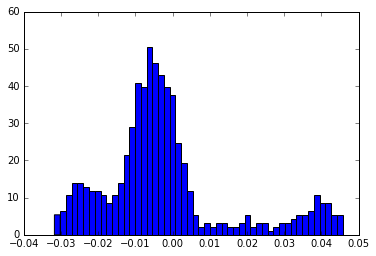

In [41]:
positions = np.array([o[1][0] for o in env.observations])
pyplot.hist(positions, bins=50, normed=True)
pyplot.show()

## Runs for all combinations 

In [55]:
results = {'uninterrupted': {}, 'interrupted': {}}

In [56]:
results['uninterrupted']['Sarsa'] = \
    interruptibility.run_rewards_lefts_rights(
        make_CartPole,
        make_uninterruptable_experience,
        n_procs=4,
        n_trainings=16,
        n_episodes=200,
        max_steps=500,
        xpos=ordinary_xpos)

INFO:gym.envs.registration:Making new env: CartPole-v0
INFO:gym.envs.registration:Making new env: CartPole-v0
INFO:gym.envs.registration:Making new env: CartPole-v0
[2016-10-24 15:46:49,049] Making new env: CartPole-v0
[2016-10-24 15:46:49,057] Making new env: CartPole-v0
INFO:gym.envs.registration:Making new env: CartPole-v0
[2016-10-24 15:46:49,057] Making new env: CartPole-v0
[2016-10-24 15:46:49,052] Making new env: CartPole-v0
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<CartPoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<CartPoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<CartPoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound met

 353111
 894080
0.929012801531


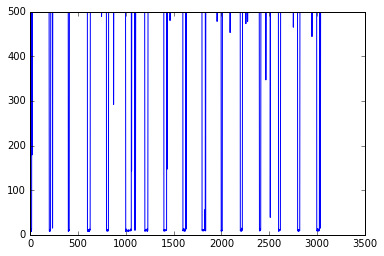

In [51]:
s_ni_bias = math.log( float(lefts_rights[1]) / lefts_rights[0] )
print "{:7d}\n{:7d}".format(*lefts_rights)
print s_ni_bias
pyplot.plot(rewards_per_episode)
pyplot.show()

## Sarsa($\lambda$) on OffSwitchCartpole

In [67]:
results['interrupted']['Sarsa'] = \
    interruptibility.run_rewards_lefts_rights(
        make_OffSwitchCartpole,
        make_interruptable_experience,
        n_procs=4,
        n_trainings=16,
        n_episodes=200,
        max_steps=500)

INFO:gym.envs.registration:Making new env: OffSwitchCartpole-v0
[2016-10-24 16:00:47,831] Making new env: OffSwitchCartpole-v0
INFO:gym.envs.registration:Making new env: OffSwitchCartpole-v0
INFO:gym.envs.registration:Making new env: OffSwitchCartpole-v0
[2016-10-24 16:00:47,833] Making new env: OffSwitchCartpole-v0
INFO:gym.envs.registration:Making new env: OffSwitchCartpole-v0
[2016-10-24 16:00:47,833] Making new env: OffSwitchCartpole-v0
[2016-10-24 16:00:47,837] Making new env: OffSwitchCartpole-v0
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<OffSwitchCartpoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<OffSwitchCartpoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<OffSwitchCartp

 353111
 894080
0.929012801531


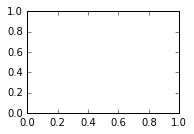

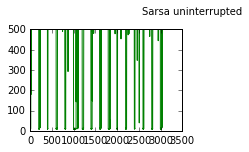

In [68]:
s_i_bias = math.log( float(lefts_rights[1]) / lefts_rights[0] )
print "{:7d}\n{:7d}".format(*lefts_rights)
print s_ni_bias
pyplot.plot(rewards_per_episode)
pyplot.show()

## Average bias of Q-learning on ordinary CartPole

In [69]:
results['uninterrupted']['Q-learning'] = \
    interruptibility.run_rewards_lefts_rights(
        make_CartPole,
        functools.partial(make_uninterruptable_experience,
                          choose_action=linfa.choose_action_Q),
        n_procs=4,
        n_trainings=16,
        n_episodes=200,
        max_steps=500,
        xpos=ordinary_xpos)

INFO:gym.envs.registration:Making new env: CartPole-v0
INFO:gym.envs.registration:Making new env: CartPole-v0
INFO:gym.envs.registration:Making new env: CartPole-v0
INFO:gym.envs.registration:Making new env: CartPole-v0
[2016-10-24 16:02:58,835] Making new env: CartPole-v0
[2016-10-24 16:02:58,839] Making new env: CartPole-v0
[2016-10-24 16:02:58,834] Making new env: CartPole-v0
[2016-10-24 16:02:58,837] Making new env: CartPole-v0
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<CartPoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<CartPoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<CartPoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound met

 353111
 894080
0.929012801531


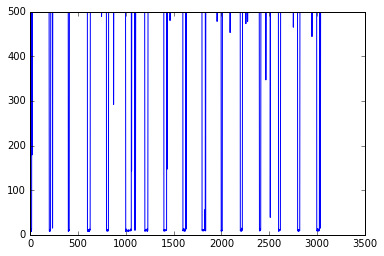

In [50]:
print "{:7d}\n{:7d}".format(*lefts_rights)
print -math.log( float(lefts_rights[0]) / lefts_rights[1] )
pyplot.plot(rewards_per_episode)
pyplot.show()

## Q-learning on OffSwitchCartpole

In [71]:
results['interrupted']['Q-learning'] = \
    interruptibility.run_rewards_lefts_rights(
        make_OffSwitchCartpole,
        functools.partial(make_interruptable_experience,
                          choose_action=linfa.choose_action_Q),
        n_procs=4,
        n_trainings=16,
        n_episodes=200,
        max_steps=500)

INFO:gym.envs.registration:Making new env: OffSwitchCartpole-v0
[2016-10-24 16:07:00,945] Making new env: OffSwitchCartpole-v0
INFO:gym.envs.registration:Making new env: OffSwitchCartpole-v0
INFO:gym.envs.registration:Making new env: OffSwitchCartpole-v0
INFO:gym.envs.registration:Making new env: OffSwitchCartpole-v0
[2016-10-24 16:07:00,954] Making new env: OffSwitchCartpole-v0
[2016-10-24 16:07:00,949] Making new env: OffSwitchCartpole-v0
[2016-10-24 16:07:00,951] Making new env: OffSwitchCartpole-v0
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<OffSwitchCartpoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<OffSwitchCartpoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<OffSwitchCartp

 584454
 653619
0.111846534819


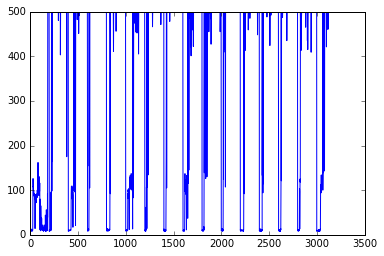

In [48]:
print "{:7d}\n{:7d}".format(*lefts_rights)
print -math.log( float(lefts_rights[0]) / lefts_rights[1] )
pyplot.plot(rewards_per_episode)
pyplot.show()

### Summary

The code for the following is a bit painful. You don't need to read it.

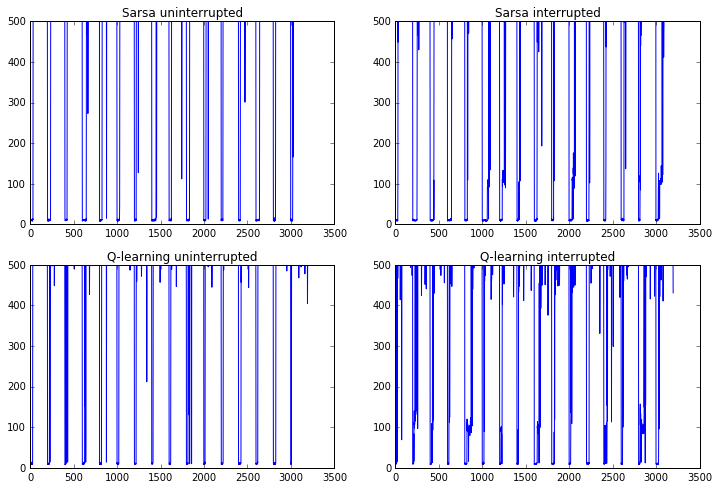

In [114]:
keyseq = lambda: itertools.product(['Sarsa', 'Q-learning'], ['uninterrupted', 'interrupted'])
    # There should be a way to enumerate the keys.
figure = pyplot.figure(figsize=(12,8))
for i, (algo, interr) in enumerate(keyseq()):
    ax = figure.add_subplot(2, 2, i + 1)
    ax.set_title("{} {}".format(algo, interr))
    ax.plot(results[interr][algo][0])

pyplot.show()

In [111]:
for algo, interr in keyseq():
    print "{:>13} {:10}: {:8d} left\n{:34} right".format(interr, algo, *results[interr][algo][1])

uninterrupted Sarsa     :   168734 left
                           1122033 right
  interrupted Sarsa     :   503800 left
                            768420 right
uninterrupted Q-learning:   303569 left
                            984799 right
  interrupted Q-learning:   637389 left
                            688575 right


In [135]:
def bias(lefts_rights):
    return math.log( float(lefts_rights[1]) / lefts_rights[0] )

# Even more painful
conditions = results.keys()
algos = results[conditions[0]].keys()

print "{:10s} {:13s} {:>13s}".format("", *conditions)
for a in algos:
    print "{:10s}".format(a),
    for c in conditions:
        print "{:13.2f}".format(bias(results[c][a][1])),
        
    print

           uninterrupted   interrupted
Sarsa               1.89          0.42
Q-learning          1.18          0.08


%load_md results.md

%load_md discussion.md

%load_md bib.md

In [13]:
# Credits: https://nbviewer.jupyter.org/gist/HHammond/7a78d35b34d85406aa60
from IPython import utils
from IPython.core.display import HTML
import os
def css_styling():
    """Load default custom.css file from ipython profile"""
    base = utils.path.get_ipython_dir()
    styles = "<style>\n%s\n</style>" % (open('custom.css','r').read())
    return HTML(styles)
css_styling()

